В этом блокноте запустил скрапинг, но в итоге перевёл его в CL скрипт, потому что там мультипроцессинг нормально работает. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

import pymorphy2
import nltk

import sys
def add_sys_path(p):
    if p not in sys.path:
        sys.path.append(p)
add_sys_path(os.path.dirname(os.getcwd()))

from test_problem import util

from tqdm import tqdm

In [2]:
INPUT_ROOT = os.path.join('..','INPUT')

In [3]:
d1 = pd.read_csv(os.path.join(INPUT_ROOT, 'dataset1.csv'), index_col=0)
print(d1.shape)
d1.head()

(270941, 15)


,PRODUCT,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Что особенно ценно - при профилактике принтера...,23.10.16 22:26:00,5.0,"хорошая скорость печати, двусторонняя печать, ...","Рядом ""на стол"" не поставишь, место много зани...",1.0,2.0,0.0
1,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Он у нас три месяца в офисе стоит уже - большо...,17.04.16 11:17:42,5.0,NaN,NaN,NaN,0.0,2.0
2,30024725,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,"Просто небо и земля с тем принтером, который у...",15.04.16 20:22:47,4.0,NaN,NaN,NaN,0.0,1.0
3,30024727,2060101,1900,ALL-IN-ONE LASER,Kyocera,REVIEW,С такой вроде бы навороченной техникой все смо...,У нас в кабинете недавно его поставили. Первое...,18.04.16 20:01:57,5.0,NaN,NaN,NaN,0.0,0.0
4,30024727,2060101,1900,ALL-IN-ONE LASER,Kyocera,REVIEW,NaN,Очень многофункциональная штука. Есть все нео...,23.04.16 12:03:39,5.0,NaN,NaN,NaN,1.0,0.0


Список продуктов, отсортированный по кол-ву отзывов. 

In [4]:
products = list(d1.PRODUCT.value_counts().index)
len(products)

36475

In [5]:
sum(d1.PRODUCT.value_counts()[0:5000])/d1.shape[0]

0.5614875563314522

In [6]:
from bs4 import BeautifulSoup
import re
import requests

Скрапаю

In [9]:
def get_price(product):
    url = r'http://www.mvideo.ru/products/'+str(product)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    div = soup.find('div', {'class': 'c-pdp-price__current sel-product-tile-price'})
    if div is None:
        return None
    price_text = re.sub('\D', '', div.contents[0])
    price = int(price_text)
    return price

In [10]:
def get_price_tuple(product):
    return product, get_price(product)

Скрапаем! Уйдёт время до ночи, но, может быть, это лучшее, что нам доступно. 

In [ ]:
prices = dict()
for product in tqdm(products):
    prices[product] = get_price(product)

  2%|█▋                                                                         | 850/36475 [34:40<22:33:13,  2.28s/it]

In [7]:
product = d1.sample(1).PRODUCT.iloc[0]
product

30013056

In [8]:
product = 20035898

In [9]:
url = r'http://www.mvideo.ru/products/'+str(product)
r = requests.get(url)
soup = BeautifulSoup(r.text, 'lxml')
div = soup.find('div', {'class': 'c-pdp-price__current sel-product-tile-price'})
print(div)
price_text = re.sub('\D', '', div.contents[0])
print(price_text)

<div class="c-pdp-price__current sel-product-tile-price">44 990¤</div>
44990


In [10]:
div is None

False

In [45]:
from joblib import Parallel, delayed

In [47]:
%time prices = [get_price_tuple(p) for p in products[0:5]]

Wall time: 13.8 s


In [48]:
print(prices)

[(10006894, 5999990), (40065249, 29990), (30027463, 8990), (30022703, None), (20031407, 9490)]


In [ ]:
from multiprocessing import Pool
p = Pool(5)
def foo(x):
    return x**2
print(p.map(foo, [1, 2, 3]))

In [ ]:
#%time prices = Parallel(n_jobs=3)(delayed(get_price_tuple)(product) for product in products[0:10])

In [ ]:
print(prices)

In [64]:
prices = dict()
for product in tqdm(products):
    prices[product] = get_price(product)

  1%|▌                                                                          | 269/36475 [07:03<16:46:27,  1.67s/it]

KeyboardInterrupt: 

In [21]:

print(div)
type(div)

<div class="c-pdp-price__current sel-product-tile-price">106 990¤</div>


bs4.element.Tag

In [24]:

??re.sub

'106990'

In [26]:
type(div.contents)

list

In [3]:
import pickle

In [4]:
with open('scrap_result.pkl', 'rb') as file:
        result = pickle.load(file)

In [6]:
dr = dict(result)

In [8]:
sr = pd.Series(dr)

In [9]:
sr.isnull().mean()

0.53710760795065116

In [12]:
sr.describe().round(-2)

count      16900.0
mean       17300.0
std        57700.0
min            0.0
25%         1800.0
50%         5800.0
75%        19800.0
max      6000000.0
dtype: float64

Большая часть цен лежит в интервале от 100 до 100000 рублей, логично. 

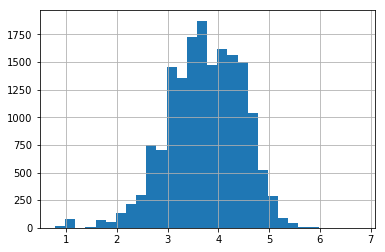

In [15]:
np.log10(sr).hist(bins=30)